# Goundwater flow model: Sampling

In [1]:
import sys
sys.path.append('./gwflow')

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import uniform, multivariate_normal

import gwflow as gwf
import tinyDA as tda

Ray module not found. Multiprocessing features are not available


/home/mikkel/venv/tinyda/lib/python3.10/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
np.random.seed(123)

In [4]:
true_parameters = np.loadtxt('true_parameters.csv')
df = pd.read_csv('data.csv')
datapoints = df[['x', 'y']].to_numpy()
data = df[['h', 'q']].to_numpy().flatten(order='F')
n_data = datapoints.shape[0]

In [5]:
my_model = gwf.PickledModel('model.p')

### Set up the statistical model

In [6]:
n_dim = my_model.parameters['conductivity_mkl']
mu_prior = np.zeros(n_dim)
sigma_prior = np.eye(n_dim)

my_prior = multivariate_normal(mu_prior, sigma_prior)

In [7]:
# set the likelihood
sigma_head = 2e-2
sigma_flux = 1e-2

cov_likelihood = np.diag(np.hstack((np.array([sigma_head**2] * n_data), np.array([sigma_flux**2] * n_data))))
my_loglike = tda.GaussianLogLike(data, cov_likelihood) 

### Set up the coarse model

In [8]:
my_model_coarse = gwf.PickledModel('model_coarse.p')
my_loglike_coarse = tda.AdaptiveGaussianLogLike(data, cov_likelihood)

### Set up LinkFactories and finding the MAP

In [9]:
# initialise the LinkFactory
my_posterior = tda.Posterior(my_prior, my_loglike, my_model)
my_posterior_coarse = tda.Posterior(my_prior, my_loglike_coarse, my_model_coarse)

In [10]:
MAP = tda.get_MAP(my_posterior, initial_parameters=mu_prior, method='CG', options={'maxiter': 100})
#MAP = np.loadtxt('MAP.csv')

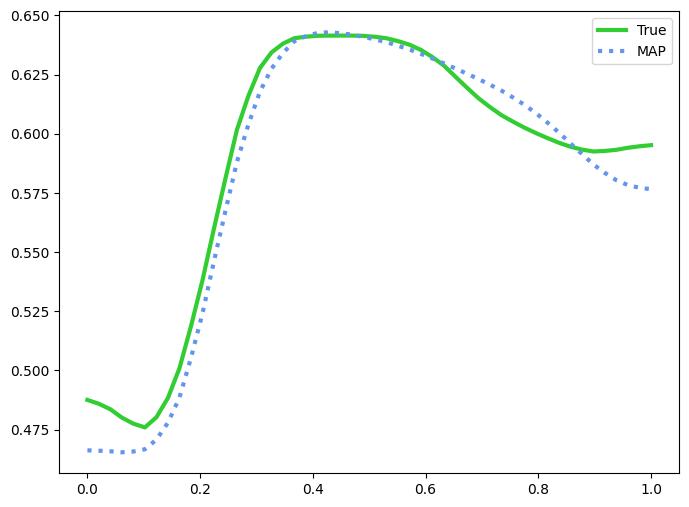

In [17]:
plt.figure(figsize=(8,6))

y_q = np.linspace(0,1)

true_parameters = np.loadtxt('true_parameters.csv')
_ = my_model(true_parameters)
q_y = np.zeros(y_q.shape[0])
for j, y in enumerate(y_q):
    q_y[j] = my_model.solver.h(0.5,y)
plt.plot(y_q, q_y, color='limegreen', linewidth=3, linestyle='solid', label='True')

_ = my_model(MAP)
q_y = np.zeros(y_q.shape[0])
for j, y in enumerate(y_q):
    q_y[j] = my_model.solver.h(0.5,y)
plt.plot(y_q, q_y, color='cornflowerblue', linewidth=3, linestyle='dotted', label='MAP')

plt.legend()
plt.show()

### Set up the proposal

In [12]:
# adaptive Metropolis
am_cov = 0.001*np.eye(my_prior.dim)
am_t0 = 2000
am_adaptive = True
my_proposal = tda.AdaptiveMetropolis(C0=am_cov, t0=am_t0, adaptive=am_adaptive)

### Initialise the chain and sample

In [13]:
# initialise the chain
my_chain = tda.sample([my_posterior_coarse, my_posterior],
                      my_proposal, 
                      iterations=25000,
                      n_chains=2,
                      initial_parameters=MAP,
                      subsampling_rate=5,
                      adaptive_error_model='state-independent')

Sampling chain 1/2


Running chain, α_c = 0.208, α_f = 0.25: 100%|█| 25000/25000 [2:48:36<00:00,  2.4


Sampling chain 2/2


Running chain, α_c = 0.174, α_f = 0.24: 100%|█| 25000/25000 [2:54:41<00:00,  2.3


### Get some diagnostics

/home/mikkel/venv/tinyda/lib/python3.10/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta_0   -1.090  0.288  -1.632   -0.554      0.020    0.014     227.0   
theta_1    0.957  0.293   0.408    1.499      0.014    0.010     413.0   
theta_2    0.260  0.229  -0.185    0.675      0.011    0.008     444.0   
theta_3   -1.412  0.251  -1.868   -0.935      0.013    0.009     380.0   
theta_4   -0.364  0.248  -0.859    0.085      0.012    0.009     407.0   
...          ...    ...     ...      ...        ...      ...       ...   
theta_123 -0.195  0.598  -1.259    0.968      0.034    0.024     316.0   
theta_124  0.085  0.511  -0.833    1.078      0.024    0.017     446.0   
theta_125  0.060  0.591  -1.057    1.129      0.037    0.026     262.0   
theta_126  0.177  0.576  -0.904    1.264      0.037    0.026     246.0   
theta_127 -0.127  0.554  -1.193    0.907      0.031    0.022     311.0   

           ess_tail  r_hat  
theta_0       316.0   1.04  
theta_1       805.0   1.00  
theta_2       900.0   1.

/home/mikkel/venv/tinyda/lib/python3.10/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (128), generating only 20 plots
  warnings.warn(


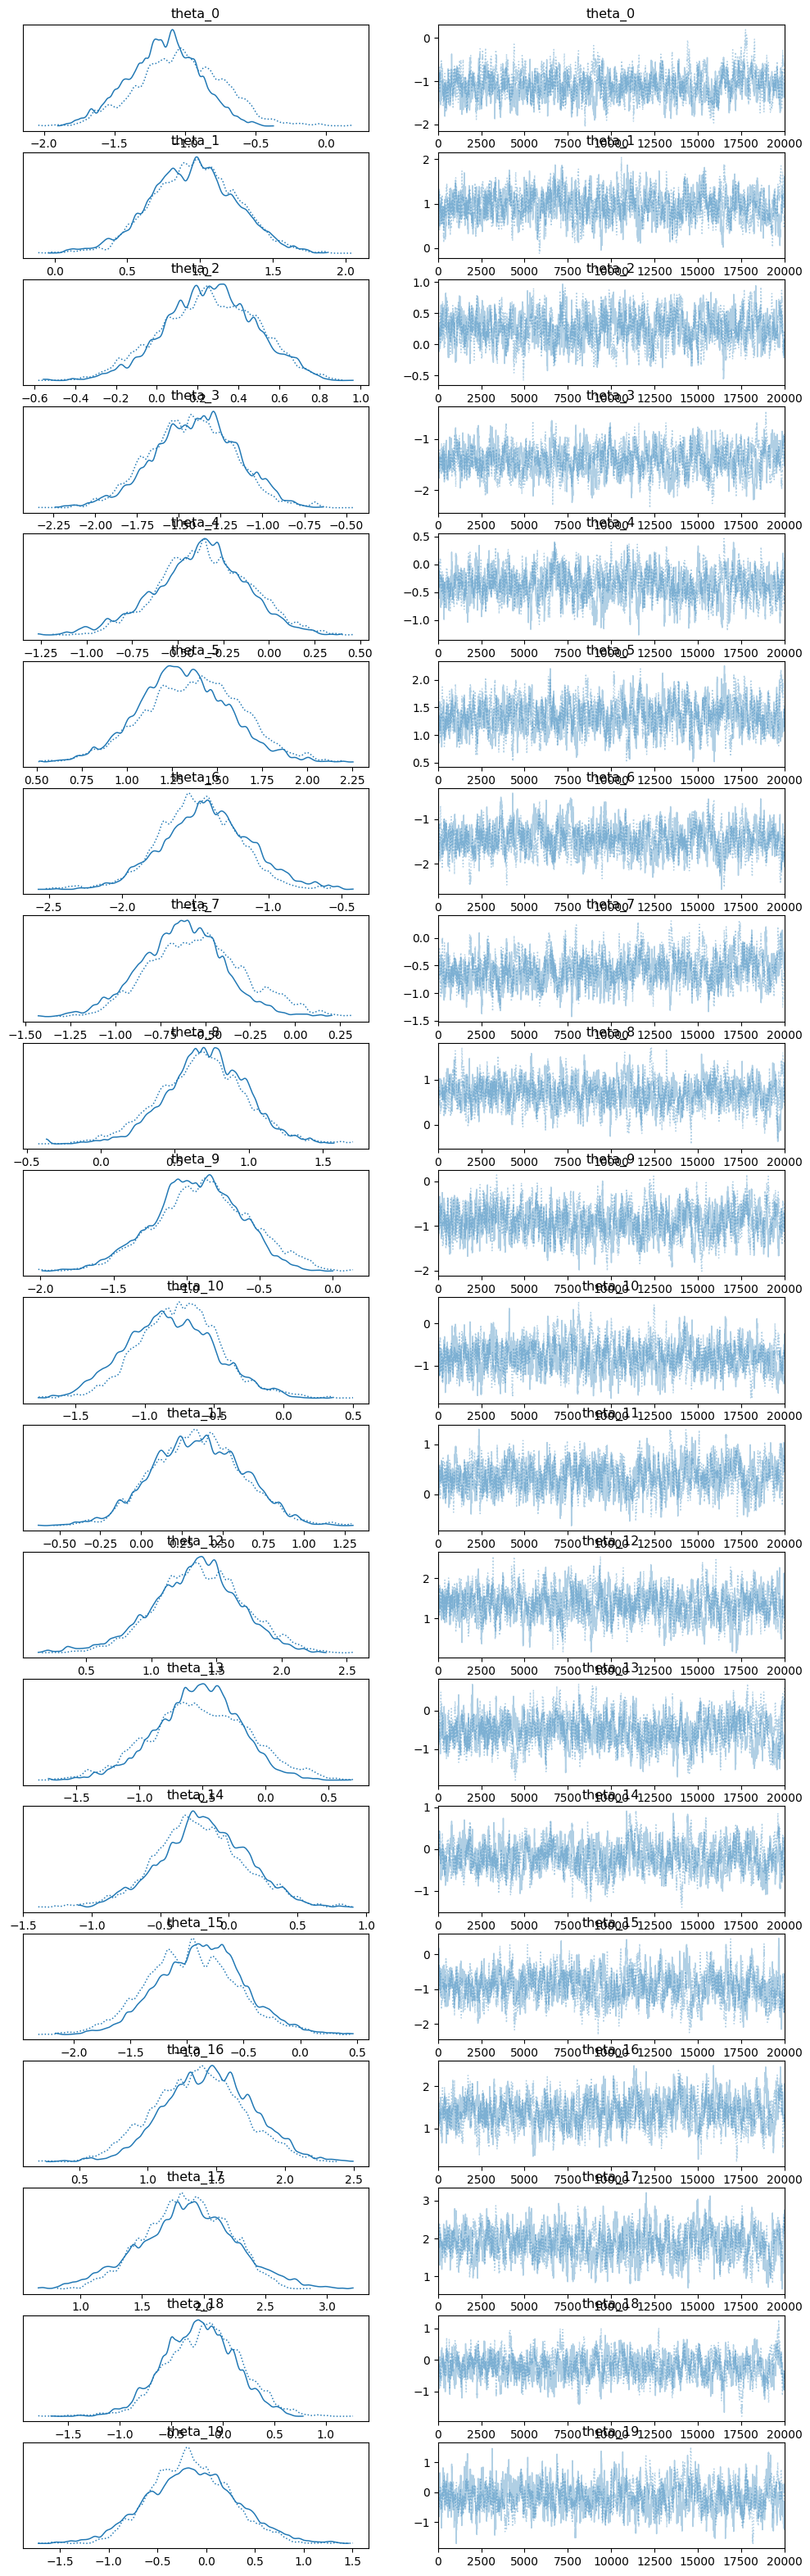

In [14]:
import arviz as az
idata = tda.to_inference_data(my_chain, level='fine', burnin=5000)
print(az.summary(idata))#.to_latex(float_format="%.3f"))
az.plot_trace(idata)
plt.show()

In [15]:
# plot some posterior samples
parameters = idata.posterior.to_dataframe().droplevel(level=0).to_numpy()

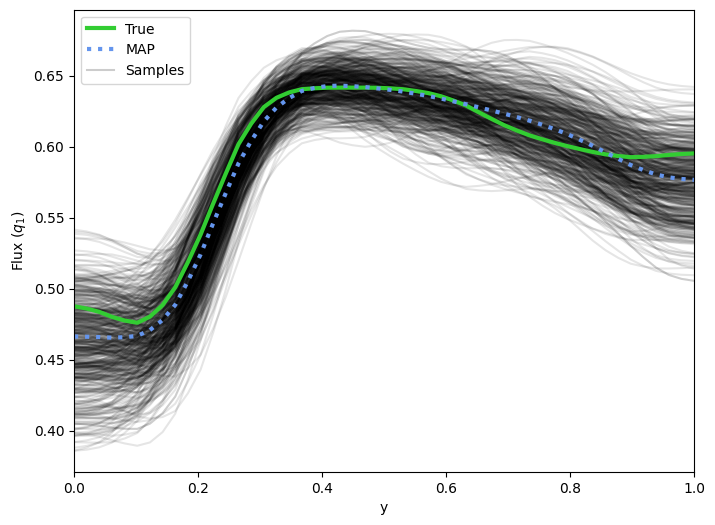

In [18]:
n_samples = 500
i_samples = np.random.choice(parameters.shape[0], n_samples, replace=False)

plt.figure(figsize=(8,6))

y_q = np.linspace(0,1)

for i in i_samples:    
    _ = my_model(parameters[i,:])
    q_y = np.zeros(y_q.shape[0])
    for j, y in enumerate(y_q):
        q_y[j] = my_model.solver.h(0.5,y)
    plt.plot(y_q, q_y, color='k', alpha=0.1)
plt.plot([], [], color='k', alpha=0.2, label='Samples')
    
_ = my_model(true_parameters)
q_y = np.zeros(y_q.shape[0])
for j, y in enumerate(y_q):
    q_y[j] = my_model.solver.h(0.5,y)
plt.plot(y_q, q_y, color='limegreen', linewidth=3, linestyle='solid', label='True')

_ = my_model(MAP)
q_y = np.zeros(y_q.shape[0])
for j, y in enumerate(y_q):
    q_y[j] = my_model.solver.h(0.5,y)
plt.plot(y_q, q_y, color='cornflowerblue', linewidth=3, linestyle='dotted', label='MAP')

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.xlabel('y'); plt.xlim(0,1)
plt.ylabel('Flux ($q_1$)')
plt.show()